In [1]:
import os
import sys
sys.path.append(os.environ.get("FASTAI_PATH"))

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
print("device is %s"%device)
torch.cuda.set_device(7)

device is cuda


### Data Prepare

The experiments are carried out on MNIST and MNIST-M datasets. The former dataset can be fetched from `fast ai` by `untar_data(URLs.MNIST)`, the latter is downloaded from this [link](https://github.com/fungtion/DANN).

In [4]:
mnist_data_path = untar_data(URLs.MNIST)

#### Generate CSV
The files in `MNIST` are categrorized by folders, while the files in `MNIST M` by .txt. In order to use the data block API in `fast ai`, we need to refactor the label infomation into a csv file. Each row in this file consists of 3 fields:
    
    filename class_label domain_label
    
where domain_label is 0 if file is from `MNIST`, otherwise 1.

In [5]:
base_path = Path("/home/shuozhao/.fastai/data/")
mnist_m_path = Path("mnist_m")

In [6]:
def genDFforM(datapath, dataset):
    mnist_m_df = pd.read_csv(datapath/f"mnist_m_{dataset}_labels.txt", sep=" ", header=None)
    file_col = mnist_m_df[0].values
    file_col = [str(mnist_m_path/f"mnist_m_{dataset}"/f) for f in file_col]
    c_labels = mnist_m_df[1].values
    s_labels = np.ones_like(c_labels)
    df = pd.DataFrame({"file":file_col, "c_label": c_labels, "s_label": s_labels})
    return df

In [7]:
m_train_df = genDFforM(base_path/mnist_m_path, "train")
m_test_df  = genDFforM(base_path/mnist_m_path, "test")

In [8]:
m_train_df.head()

,file,c_label,s_label
0,mnist_m/mnist_m_train/00000000.png,5,1
1,mnist_m/mnist_m_train/00000001.png,0,1
2,mnist_m/mnist_m_train/00000002.png,4,1
3,mnist_m/mnist_m_train/00000003.png,1,1
4,mnist_m/mnist_m_train/00000004.png,9,1


In [9]:
m_train_df["c_label"].value_counts()

1    6640
7    6158
3    6028
2    5853
9    5851
0    5825
6    5812
8    5757
4    5746
5    5331
Name: c_label, dtype: int64

In [10]:
type(m_test_df.c_label)

pandas.core.series.Series

In [11]:
m_test_df.c_label.value_counts()

1    1016
2     933
9     919
7     914
3     908
4     890
8     880
0     878
6     856
5     807
Name: c_label, dtype: int64

In [12]:
mnist_path = Path("mnist_png")

In [13]:
def genDFforB(datapath, dataset):
    files = (datapath/dataset).rglob("*.png")
    file_names = [str(f.relative_to(base_path)) for f in files]
    c_labels = [int(f.split("/")[2]) for f in file_names]
    s_labels = np.zeros_like(c_labels)
    return DataFrame({"file":file_names, "c_label": c_labels, "s_label": s_labels})

In [14]:
b_train_df = genDFforB(base_path/mnist_path, "training")
b_test_df = genDFforB(base_path/mnist_path, "testing")

In [15]:
b_train_df["c_label"].value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: c_label, dtype: int64

In [16]:
b_test_df["c_label"].value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: c_label, dtype: int64

In [17]:
b_train_df.head()

,file,c_label,s_label
0,mnist_png/training/9/12884.png,9,0
1,mnist_png/training/9/40297.png,9,0
2,mnist_png/training/9/55247.png,9,0
3,mnist_png/training/9/364.png,9,0
4,mnist_png/training/9/15244.png,9,0


In [18]:
train_df = pd.concat([m_train_df, b_train_df])
test_df = pd.concat([m_test_df, b_test_df])
train_df.to_csv(base_path/"DA_mnist_train.csv", index=False)
test_df.to_csv(base_path/"DA_mnist_test.csv", index=False)

In [19]:
m_train_df.to_csv(base_path/"target_mnist_train.csv", index=False)
m_test_df.to_csv(base_path/"target_mnist_test.csv", index=False)
b_test_df.to_csv(base_path/"source_mnist_test.csv", index=False)
b_train_df.to_csv(base_path/"source_mnist_train.csv", index=False)

In [20]:
test_df.shape

(19001, 3)

### Model Definition
Gradient Reversal Layer: this is borrowed from this [repo](https://github.com/KeiraZhao/MDAN/blob/master/model.py). It seems taking negatives on grad_output inplace by `grad_output.clone()` also works.

In [21]:
class GradientReversalLayer(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """
    def forward(self, inputs):
        return inputs

    def backward(self, grad_output):
#         output = grad_output.neg()
        grad_input = grad_output.clone()
        output = -grad_input
        return output

In [22]:
img_size=32
batch_size = 512
n_class = 10
n_body = 1024

In [23]:
data = (
    ImageList.from_csv(path=base_path, csv_name="DA_mnist_train.csv")
    .split_by_rand_pct(0.2)
    .label_from_df(cols=[1,2], label_cls=FloatList)
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [24]:
class CustomHead(torch.nn.Module):
    def __init__(self, n_class=10):
        super(CustomHead, self).__init__()
        self.pool = AdaptiveConcatPool2d()
        self.flat = Flatten()
        
        n_hidden = 512
        self.c_classifer = nn.Sequential(
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(p=0.25),
            nn.Linear(n_body, n_hidden),
            nn.ReLU(inplace=True),
            
            nn.BatchNorm1d(num_features=n_hidden),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden, n_class)
        )
        
        self.GRL = GradientReversalLayer()
        self.s_classifer = nn.Sequential(
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(p=0.25),
            nn.Linear(n_body, n_hidden),
            nn.ReLU(inplace=True),
            
            nn.BatchNorm1d(num_features=n_hidden),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden, 1)
        )
    
    def forward(self, x):
        x = self.pool(x)
        x = self.flat(x)
        c_score = self.c_classifer(x)
        s_score = self.s_classifer(self.GRL(x))
        return torch.cat([c_score, s_score], dim=1)
#         return [c_score, s_score]

In [25]:
class CusCE(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()
#         self.cl = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight).to(device)
        self.cl = nn.CrossEntropyLoss().to(device)
#         self.cl = nn.BCEWithLogitsLoss().to(device)
        self.sl = nn.BCEWithLogitsLoss().to(device)
        self.n_class = n_class
        

    def forward(self, inputs, targets, **kwargs):
        c_score, s_score = inputs[:,:self.n_class], inputs[:,-1]
        c_targets = targets[:,0].long()
        s_targets = targets[:,1]
        loss = self.cl(c_score, c_targets) + self.sl(s_score, s_targets)
        return loss

In [26]:
def c_accuracy_helper(source_domain=0):
    names = ["source_c_accuracy", "target_c_accuracy"]
    def c_accuracy(inputs, targets):
        input_c = inputs[:, :n_class] #.flatten()
        x = torch.argmax(input_c,dim=1)
        targets = targets.long()
        target_c = targets[:, 0]
        target_c = target_c[targets[:,1]==source_domain]
        x = x[targets[:,1]==source_domain]
        return (x==target_c).float().mean()
    c_accuracy.__name__ = names[source_domain]
    return c_accuracy

def s_accuracy(input, targets):
    input_s = input[:,-1] #.flatten()
#     x = torch.argmax(input_s)
    x = input_s.clone().squeeze()
    x[x>0] = 1
    x[x<0] = 0
    target_s = targets[:, 1].long()
    return (x.long()==target_s).float().mean()

In [27]:
source_c_accuracy = c_accuracy_helper(source_domain=0)
target_c_accuracy = c_accuracy_helper(source_domain=1)

If use partial to define the monitoring metrics, it is unable to change the names of metric functions.

In [28]:
# from functools import partial
# def c_accuracy(input, targets, source_domain=0):
#     input_c = input[0] #.flatten()
#     x = torch.argmax(input_c, dim=1)
#     targets = targets.long()
#     target_c = targets[:, 0]
#     target_c = target_c[targets[:,1]==source_domain]
#     x = x[targets[:,1]==source_domain]
#     return (x==target_c).float().mean()

# source_c_accuracy = partial(c_accuracy,source_domain=0)
# target_c_accuracy = partial(c_accuracy,source_domain=1)

In [29]:
learn = cnn_learner(data, models.resnet34, pretrained=True, custom_head=CustomHead(), 
                    metrics=[source_c_accuracy, target_c_accuracy, s_accuracy], loss_func=CusCE())

In [30]:
learn.unfreeze()

In [31]:
source_c_accuracy.__name__

'source_c_accuracy'

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,source_c_accuracy,target_c_accuracy,s_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.74E-02


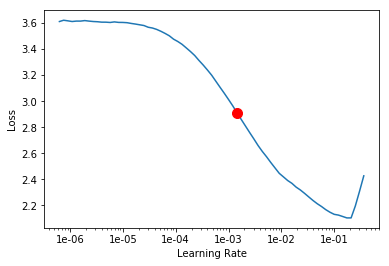

In [33]:
learn.recorder.plot(suggestion=True)

In [34]:
learn.fit_one_cycle(20, max_lr=1E-2)

epoch,train_loss,valid_loss,source_c_accuracy,target_c_accuracy,s_accuracy,time
0,0.666132,0.656193,0.983607,0.920114,0.777857,00:21
1,0.807568,0.807498,0.985414,0.930999,0.635714,00:21
2,0.800937,0.839161,0.979623,0.936126,0.578781,00:21
3,0.786121,0.827562,0.980334,0.942588,0.598151,00:21
4,0.773440,0.793700,0.986994,0.949311,0.582269,00:21
5,0.762014,0.811720,0.984455,0.944797,0.562437,00:21
6,0.739741,0.788913,0.985680,0.950882,0.577143,00:21
7,0.740135,0.776357,0.988911,0.947578,0.596975,00:21
8,0.729308,0.749384,0.991309,0.962474,0.584622,00:21
9,0.716868,0.763590,0.990622,0.960849,0.586134,00:21


In [35]:
data_test = (
    ImageList.from_csv(path=base_path, csv_name="DA_mnist_test.csv")
    .split_none()
    .label_from_df(cols=[1,2], label_cls=FloatList)
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [36]:
learn.data = data_test

In [37]:
data_test

ImageDataBunch;

Train: LabelList (19001 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: FloatList
[7. 1.],[2. 1.],[1. 1.],[0. 1.],[4. 1.]
Path: /home/shuozhao/.fastai/data;

Valid: LabelList (0 items)
x: ImageList

y: FloatList

Path: /home/shuozhao/.fastai/data;

Test: None

In [38]:
res = learn.get_preds(DatasetType.Train)

In [39]:
def show_result(y_preds, labels):
    
    c_labels = labels[:,0].clone().numpy().astype(np.int)
    s_labels = labels[:,1].clone().numpy().astype(np.int)
    
    c_scores, s_scores = y_preds[:,:n_class].numpy(), y_preds[:,-1].numpy()
    c_preds = np.argmax(c_scores, axis=1)
    s_scores[s_scores>0] = 1
    s_scores[s_scores<=0] = 0
    s_preds = s_scores.astype(np.int)
    
    
    print("For classification: %d out of %d are correctly classified"%((c_preds==c_labels).sum(), len(c_labels)))
    print("For data source: %d out of %d are correctly recognized"%((s_preds==s_labels).sum(),len(s_labels)))
    
    source_c_labels = c_labels[s_labels==0]
    target_c_labels = c_labels[s_labels==1]
    
    source_c_preds = c_preds[s_labels==0]
    target_c_preds = c_preds[s_labels==1]
    
    source_right_no = (source_c_labels==source_c_preds).sum()
    target_right_no = (target_c_labels==target_c_preds).sum()
    
    source_c_acc = source_right_no/len(source_c_labels)
    target_c_acc = target_right_no/len(target_c_labels)
    print("For source data: %d out of %d (Acc %.4f) are correctly classified" \
              %(source_right_no, len(source_c_labels), source_c_acc))
    print("For target data: %d out of %d (Acc %.4f) are correctly classified" \
              %(target_right_no, len(target_c_labels), target_c_acc))

In [40]:
show_result(res[0], res[1])

For classification: 18691 out of 18944 are correctly classified
For data source: 11297 out of 18944 are correctly recognized
For source data: 9926 out of 9975 (Acc 0.9951) are correctly classified
For target data: 8765 out of 8969 (Acc 0.9773) are correctly classified


### Baseline: Training on MNIST, Inference on MNIST-M

In [41]:
data = (
    ImageList.from_csv(path=base_path, csv_name="source_mnist_train.csv")
    .split_by_rand_pct(0.2)
    .label_from_df()
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [42]:
best_model_pth = "mnist_resnet34"
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)

In [43]:
learn.fit_one_cycle(3, 5E-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.213130,0.697619,0.817167,00:09
1,0.089176,0.085032,0.976000,00:09
2,0.043496,0.030660,0.992167,00:09


In [44]:
learn.unfreeze()
best_model = "mnist_resnet34"
learn.fit_one_cycle(20, slice(1E-5, 1E-3), 
                    callbacks=[SaveModelCallback(learn, name=best_model, monitor="accuracy", mode="max"),
                              EarlyStoppingCallback(learn, monitor="accuracy", min_delta=0.001, patience=5)])

epoch,train_loss,valid_loss,accuracy,time
0,0.021127,0.029087,0.992583,00:11
1,0.020451,0.028018,0.992667,00:11
2,0.020521,0.030040,0.992250,00:11
3,0.018643,0.033881,0.991250,00:11
4,0.018835,0.037619,0.991167,00:11
5,0.015390,0.032875,0.991500,00:11


Better model found at epoch 0 with accuracy value: 0.9925833344459534.
Better model found at epoch 1 with accuracy value: 0.9926666617393494.
Epoch 6: early stopping


In [45]:
data_test_mnist = (
    ImageList.from_csv(path=base_path, csv_name="source_mnist_test.csv")
    .split_none()
    .label_from_df()
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [46]:
learn.data = data_test_mnist

In [47]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

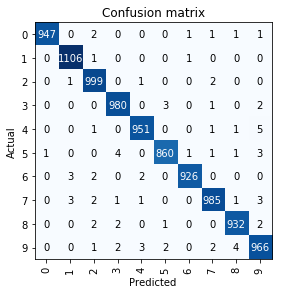

In [48]:
interp.plot_confusion_matrix()

In [49]:
conf_mat = interp.confusion_matrix()
acc = np.sum(np.diag(conf_mat))/np.sum(conf_mat)
acc

0.9921875

In [50]:
data_test_mnist_m = (
    ImageList.from_csv(path=base_path, csv_name="target_mnist_test.csv")
    .split_none()
    .label_from_df()
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [51]:
learn.data = data_test_mnist_m

In [52]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

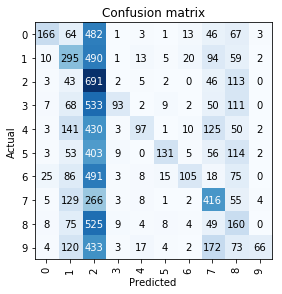

In [53]:
interp.plot_confusion_matrix()

In [54]:
conf_mat = interp.confusion_matrix()
acc = np.sum(np.diag(conf_mat))/np.sum(conf_mat)
acc

0.25505514705882354

### Training on MNIST-M, Inferencing on MNIST-M

In [55]:
data = (
    ImageList.from_csv(path=base_path, csv_name="target_mnist_train.csv")
    .split_by_rand_pct(0.2)
    .label_from_df()
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [56]:
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=accuracy)

In [57]:
learn.fit_one_cycle(5, 5E-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.954437,1.016632,0.755254,00:10
1,0.452798,0.509846,0.841356,00:08
2,0.311436,0.359692,0.885000,00:09
3,0.232098,0.215975,0.930678,00:08
4,0.168180,0.178532,0.940170,00:08


In [58]:
learn.unfreeze()
best_model = "mnist_m_resnet34"
learn.fit_one_cycle(20, slice(1E-5, 1E-3), 
                    callbacks=[SaveModelCallback(learn, name=best_model, monitor="accuracy", mode="max"),
                              EarlyStoppingCallback(learn, monitor="accuracy", min_delta=0.001, patience=5)])

epoch,train_loss,valid_loss,accuracy,time
0,0.146835,0.178005,0.940339,00:11
1,0.140776,0.176406,0.942119,00:11
2,0.134210,0.182031,0.941864,00:11
3,0.131291,0.178678,0.943390,00:11
4,0.118017,0.181135,0.942966,00:11
5,0.105084,0.172613,0.945085,00:11
6,0.090217,0.182138,0.946102,00:11
7,0.075114,0.207796,0.940678,00:11
8,0.061094,0.197686,0.946102,00:11
9,0.047571,0.194360,0.948136,00:11


Better model found at epoch 0 with accuracy value: 0.9403389692306519.
Better model found at epoch 1 with accuracy value: 0.9421186447143555.
Better model found at epoch 3 with accuracy value: 0.9433898329734802.
Better model found at epoch 5 with accuracy value: 0.9450847506523132.
Better model found at epoch 6 with accuracy value: 0.9461016654968262.
Better model found at epoch 9 with accuracy value: 0.9481356143951416.
Better model found at epoch 11 with accuracy value: 0.9505932331085205.
Better model found at epoch 17 with accuracy value: 0.9512711763381958.
Epoch 17: early stopping


In [59]:
data_test_mnist_m = (
    ImageList.from_csv(path=base_path, csv_name="target_mnist_test.csv")
    .split_none()
    .label_from_df()
    .transform(size=img_size)
    .databunch(bs=batch_size)
    .normalize(imagenet_stats)
)

In [60]:
learn.data = data_test_mnist_m

In [61]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

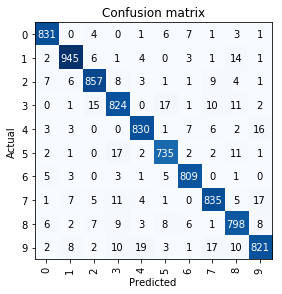

In [62]:
interp.plot_confusion_matrix()

In [63]:
conf_mat = interp.confusion_matrix()
acc = np.sum(np.diag(conf_mat))/np.sum(conf_mat)
acc

0.9518612132352942